# Task 1: Text Mining & NLP

## Libraries

In [1]:
import pandas as pd
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from nltk.corpus import stopwords  
from wordcloud import WordCloud,STOPWORDS
from nltk import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import datasets, layers, models, losses

from prettytable import PrettyTable, ALL

from gensim.models import Word2Vec

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1.Exploring and preparing the data

### Reading the file

In [2]:
data = open('training.1600000.processed.noemoticon.csv',"r")
data

<_io.TextIOWrapper name='training.1600000.processed.noemoticon.csv' mode='r' encoding='cp1252'>

In [3]:
# construct the file path to the CSV file
file_path = 'training.1600000.processed.noemoticon.csv'

# load the data using the `pandas.read_csv` function
df = pd.read_csv(file_path, encoding='cp1252',names={0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'})

# rename columns
df.columns= ['target', 'ids', 'date', 'flag','user','text']

df.tail()

,target,ids,date,flag,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


- Taking a sample of data of 20%

In [4]:
df = df.sample(frac=0.2)

In [5]:
# calculate number of rows and columns
df.shape

(320000, 6)

In [6]:
# data informtions
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320000 entries, 1419261 to 1295610
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  320000 non-null  int64 
 1   ids     320000 non-null  int64 
 2   date    320000 non-null  object
 3   flag    320000 non-null  object
 4   user    320000 non-null  object
 5   text    320000 non-null  object
dtypes: int64(2), object(4)
memory usage: 17.1+ MB


In [7]:
# calculate number of missing values
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
# check number of duplications
print(df.duplicated().loc[lambda x : x == True].count())

0


### 1.1 Stopwords is applied inside the data cleaning part

- Stopword removal can help reduce the size of the dataset and remove noise that is unlikely to be meaningful.

In [9]:
# remove URl
def rem_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# remove stopwords 'english'
def rem_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    return text

# remove html  
def rem_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

def remove_at_mentions(text):
    return re.sub(r'@\w+', '', text)

# Fixing the text
def fixing(text):
    text = re.sub(r"Mr\'s", " he is", text)
    text = re.sub(r"Mr\'.", " he is", text)
    text = re.sub(r"Ms\'.", " She ", text)
    text = re.sub(r"She\'s", " she is", text)
    text = re.sub(r"I\'m", " i am", text)
    text = re.sub(r"haven\'t", " have not", text)
    text = re.sub(r"you\'r", " you are", text)
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r" plz", " please", text)
    text = re.sub(r"it\'s", " its", text) 
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"He\'s", " he is", text)
    text = re.sub(r"in\'s", " in", text)
    return text

# seperate alphabets
def sep_alphabets(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

df['final_text'] = df['text']

df['final_text'] = df['final_text'].astype(str).apply(remove_at_mentions)
df['final_text'] = df['final_text'].apply(lambda x : rem_url(x))
df['final_text'] = df['final_text'].apply(lambda x : rem_stopwords(x))
df['final_text'] = df['final_text'].apply(lambda x : tweet_to_words(x))
df['final_text'] = df['final_text'].apply(lambda x : fixing(x))
df['final_text'] = df['final_text'].apply(lambda x : rem_html(x))
df['final_text'] = df['final_text'].apply(lambda x : sep_alphabets(x))

In [10]:
df[['text', 'final_text']].head(10)

,text,final_text
1419261,finally getting to bed - will post up the funn...,finally getting bed post funniest video moots ...
626115,wants to get fucked up.,wants get fucked
625694,fuck you final cut. fuck you. The force quit w...,fuck final cut fuck force quit wiped save file...
1129357,@Victor_Lucas How's the framerate on this &quo...,framerate quot outside quot game speak
316707,@__DearAngel__x iÂ´m listen i kiss a girl-kat...,listen kiss girl katy perry wanna manicure eng
240346,Miss that time together,miss time together
529582,To my physics professor... you're boring and s...,physics professor boring slow yay day
560629,my twitter updates arent coming to my phone an...,twitter updates arent coming phone anymore
217888,@jr_smith1 @stephenasmith good job u made very...,good job u made far lakers
749197,@pamelapena I really wish you could be here......,really wish could really needing


### 1.2 Tokenization

-  Tokenization facilitate text processing and analysis. By breaking text up into individual tokens, it becomes easier to perform operations such as searching, sorting, and indexing.

In [11]:
# define a function to perform the tokenization
def tokenize(text):
  return text.split()

# apply the tokenization function to the 'text' column
df['tokenized_text'] = df['final_text'].apply(tokenize)
df[['final_text', 'tokenized_text']].head(10)

,final_text,tokenized_text
1419261,finally getting bed post funniest video moots ...,"[finally, getting, bed, post, funniest, video,..."
626115,wants get fucked,"[wants, get, fucked]"
625694,fuck final cut fuck force quit wiped save file...,"[fuck, final, cut, fuck, force, quit, wiped, s..."
1129357,framerate quot outside quot game speak,"[framerate, quot, outside, quot, game, speak]"
316707,listen kiss girl katy perry wanna manicure eng,"[listen, kiss, girl, katy, perry, wanna, manic..."
240346,miss time together,"[miss, time, together]"
529582,physics professor boring slow yay day,"[physics, professor, boring, slow, yay, day]"
560629,twitter updates arent coming phone anymore,"[twitter, updates, arent, coming, phone, anymore]"
217888,good job u made far lakers,"[good, job, u, made, far, lakers]"
749197,really wish could really needing,"[really, wish, could, really, needing]"


### 1.3 Stemming

-  Stemming involves reducing a word to its base form, or stem. This help identify the root of a word, even it is modified with prefixes or suffixes.

In [12]:
# Create a Snowball stemmer
stemmer = SnowballStemmer('english')

# Define a function to stem a string
def stem_string(text):
  tokens = text.split()
  stemmed_tokens = [stemmer.stem(token) for token in tokens]
  return ' '.join(stemmed_tokens)

# Apply the stemmer to the 'final_text' column
df['stemmed_text'] = df['tokenized_text'].apply(lambda x: stem_string(' '.join(x)))

df[['final_text', 'tokenized_text', 'stemmed_text']].head(10)

,final_text,tokenized_text,stemmed_text
1419261,finally getting bed post funniest video moots ...,"[finally, getting, bed, post, funniest, video,...",final get bed post funniest video moot morn night
626115,wants get fucked,"[wants, get, fucked]",want get fuck
625694,fuck final cut fuck force quit wiped save file...,"[fuck, final, cut, fuck, force, quit, wiped, s...",fuck final cut fuck forc quit wipe save file b...
1129357,framerate quot outside quot game speak,"[framerate, quot, outside, quot, game, speak]",framer quot outsid quot game speak
316707,listen kiss girl katy perry wanna manicure eng,"[listen, kiss, girl, katy, perry, wanna, manic...",listen kiss girl kati perri wanna manicur eng
240346,miss time together,"[miss, time, together]",miss time togeth
529582,physics professor boring slow yay day,"[physics, professor, boring, slow, yay, day]",physic professor bore slow yay day
560629,twitter updates arent coming phone anymore,"[twitter, updates, arent, coming, phone, anymore]",twitter updat arent come phone anymor
217888,good job u made far lakers,"[good, job, u, made, far, lakers]",good job u made far laker
749197,really wish could really needing,"[really, wish, could, really, needing]",realli wish could realli need


### 1.4 Visualization

- Number of tweets per date visualized in a table 

In [13]:
# number of tweets per date
df['date'] = pd.to_datetime(df['date']).dt.date
tweets_per_date = df.groupby('date').size()
tweets_per_date=tweets_per_date.reset_index()
tweets_per_date.columns=['Date', 'Number of Tweets']
tweets_per_date.sort_values(by= ['Number of Tweets'], ascending= False).head(10)

,Date,Number of Tweets
34,2009-06-06,22512
29,2009-06-01,22052
37,2009-06-15,21988
27,2009-05-30,20690
35,2009-06-07,19368
28,2009-05-31,19052
26,2009-05-29,14693
38,2009-06-16,13467
30,2009-06-02,12788
33,2009-06-05,11712


- Number of tweets per date visualized in a barplot

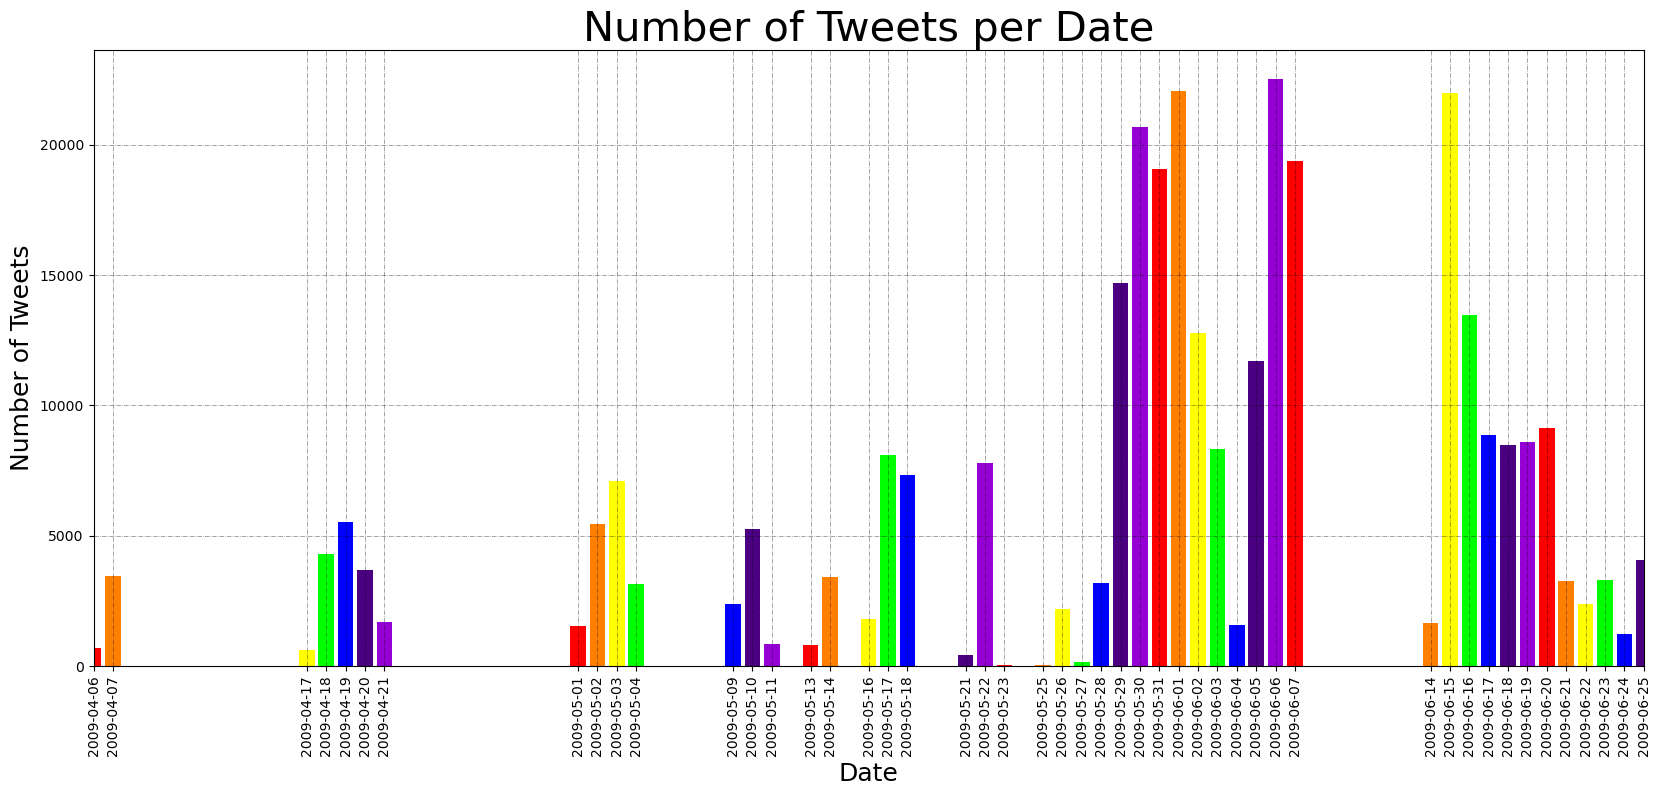

In [14]:
# Group the data by date and count the number of tweets per date
tweets_per_date = df.groupby('date').size()

# Extract the dates and the number of tweets
dates = tweets_per_date.index
tweets = tweets_per_date.values

# Create a figure with a wider width
fig = plt.figure(figsize=(20, 8))

# Create a list of rainbow colors
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#9400D3']

# Create a bar chart
plt.bar(dates, tweets, color=colors)

# Set the x-axis limits to include all of the dates
plt.xlim(dates[0], dates[-1])

# Rotate the x-tick labels by 45 degrees
plt.xticks(dates[::1], rotation=90)

# Add labels to the axes
plt.xlabel('Date', fontsize=18)
plt.ylabel('Number of Tweets', fontsize= 18)

# add title
plt.title("Number of Tweets per Date", fontsize= 30)

# add grid
plt.grid(color = "black", linewidth = "0.5", linestyle = "-.",alpha=0.5)

# Show the plot
plt.show()

##### Number of tweets per target visualized in barplot
- The results show % of positve and negative tweets

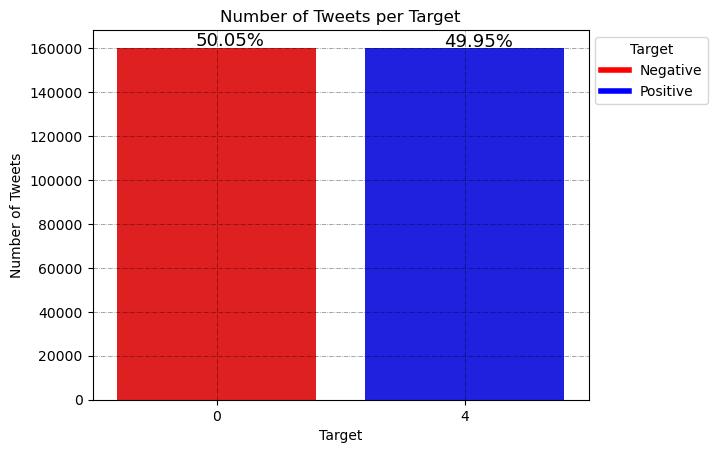

In [15]:
# Define a function to add labels to the bar plots
def labels(ax, df, xytext=(10,5)):
    # Iterate over the bars in the plot
    for bar in ax.patches:
        # Calculate the percentage of each bar
        percent = 100 * bar.get_height() / len(df)
        # Add the percentage label to the plot
        ax.annotate('{:.2f}%'.format(percent), 
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                    ha='center', va='center', size=13, xytext=xytext, textcoords='offset points')

# Create a bar plot of the target column
ax = sb.countplot(data=df, x='target', palette=['red', 'blue'])
# Add labels to the plot
labels(ax, df)

# Add a legend to the plot
legend_elements = [plt.Line2D([0], [0], color='red', lw=4, label='Negative'), 
                   plt.Line2D([0], [0], color='blue', lw=4, label='Positive')]
plt.legend(title="Target" ,handles=legend_elements, bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

# Add a title, x-axis label, and y-axis label to the plot
plt.title("Number of Tweets per Target")
plt.xlabel("Target")
plt.ylabel("Number of Tweets")

plt.grid(color = "black", linewidth = "0.5", linestyle = "-.", alpha=0.5);

# Show the plot
plt.show()

## 2.Bag-of-words (BOW), KNN, DT and SVM

### Build a BOW model

In [16]:
# Build the BOW model using CounterVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.stemmed_text)
y = df.target

In [17]:
vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

### Split data into train and test

In [18]:
# split the data into training and testing  
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=45)

### Models

#### 2.1 KNN

##### Create Model

In [19]:
# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

##### Predict

In [20]:
# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

#### 2.2 Decision Tree

##### Create Model

In [21]:
# Train the decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

##### Predict

In [22]:
# Make predictions on the test set
y_pred_dt = dt.predict(X_test)

#### 2.3 SVM

##### Create Model

In [23]:
# Train the SVM model
svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC()

##### Predict

In [24]:
# Make predictions on the test set
y_pred_svm = svm.predict(X_test)

## 3.Evaluating the models (KNN, DT and SVM)

### 3.1 Accuracy Checking

In [25]:
# Calculate the accuracy of the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Calculate the accuracy of the decision tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Calculate the accuracy of the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Create a list of dictionaries with the results for each model
results = [
    {'Model': 'KNN', 'Accuracy': accuracy_knn},
    {'Model': 'Decision Tree', 'Accuracy': accuracy_dt},
    {'Model': 'SVM', 'Accuracy': accuracy_svm}
]

# Create the DataFrame
df_models = pd.DataFrame(results, columns=['Model', 'Accuracy'])

# Display the DataFrame
df_models

,Model,Accuracy
0,KNN,0.677312
1,Decision Tree,0.694375
2,SVM,0.753766


### 3.2 Classification Report

In [26]:
# Create a PrettyTable object
table = PrettyTable(hrules=ALL)

# Set the column names
table.field_names = ["Model", "Classification Report"]


# Add the classification reports for each model to the table
table.add_row(["KNN", classification_report(y_test, y_pred_knn)])
table.add_row(["Decision Tree", classification_report(y_test, y_pred_dt)])
table.add_row(["SVM", classification_report(y_test, y_pred_svm)])

# Print the table
print(table)

+---------------+-------------------------------------------------------+
|     Model     |                 Classification Report                 |
+---------------+-------------------------------------------------------+
|      KNN      |               precision    recall  f1-score   support |
|               |                                                       |
|               |            0       0.70      0.63      0.66     32044 |
|               |            4       0.66      0.72      0.69     31956 |
|               |                                                       |
|               |     accuracy                           0.68     64000 |
|               |    macro avg       0.68      0.68      0.68     64000 |
|               | weighted avg       0.68      0.68      0.68     64000 |
|               |                                                       |
+---------------+-------------------------------------------------------+
| Decision Tree |               precis

### 3.3 Confusion Matrix

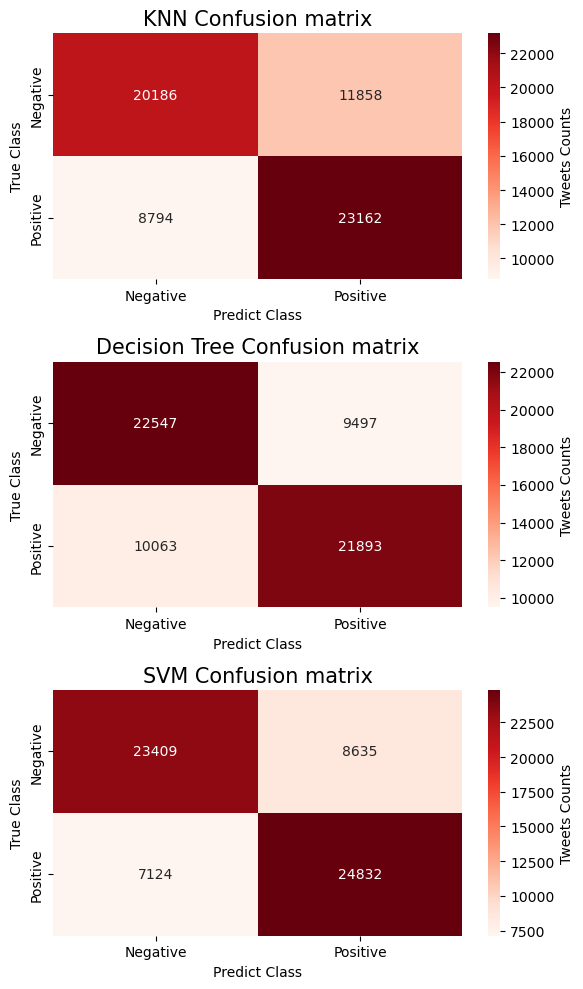

In [27]:
# KNN confusion matrix
CM_KNN = confusion_matrix(y_test,y_pred_knn)

# Decision Tree confusion matrix
CM_DT = confusion_matrix(y_test, y_pred_dt)

# SVM confusion matrix
CM_SVM = confusion_matrix(y_test, y_pred_svm)

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3)= plt.subplots(3,1, figsize=(6, 10))

LS_labels = ['Negative', 'Positive']

# Plot the KNN confusion matrix
sb.heatmap(CM_KNN, cmap = plt.cm.Reds, ax= ax1, annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax1.set_xlabel('Predict Class', fontsize = 10)
ax1.set_ylabel('True Class', fontsize = 10)
ax1.set_title('KNN Confusion matrix', fontsize = 15)

# Plot the Decision Tree confusion matrix
sb.heatmap(CM_DT, cmap = plt.cm.Reds, ax= ax2, annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax2.set_xlabel('Predict Class', fontsize = 10)
ax2.set_ylabel('True Class', fontsize = 10)
ax2.set_title('Decision Tree Confusion matrix', fontsize = 15)

# Plot the SVM confusion matrix
sb.heatmap(CM_SVM, cmap = plt.cm.Reds, ax= ax3, annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax3.set_xlabel('Predict Class', fontsize = 10)
ax3.set_ylabel('True Class', fontsize = 10)
ax3.set_title('SVM Confusion matrix', fontsize = 15)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

- We used bag-of-words (BOW) to extract features from a dataset and then evaluated the performance of three machine learning algorithms - support vector machines (SVM), decision trees (DT), and k-nearest neighbors (KNN) - on the transformed data. The results showed that SVM had the highest accuracy, followed by DT and then KNN. These findings suggest that SVM may be the most suitable algorithm for this particular task when using BOW for feature extraction.

## 4.Word Embedding, CNN

- Split data into train and test

In [28]:
# split the data into training and testing  
train, test = train_test_split(df, test_size=0.3, random_state=15)

- Apply tokenizing

In [29]:
# Apply Tokenizer
vectorizer = Tokenizer()
vectorizer.fit_on_texts(train.stemmed_text)

In [30]:
len(vectorizer.word_index)

66117

- Get the maximum words from the stemmed text

In [31]:
max_word_count = df['stemmed_text'].apply(lambda x: len(x.split())).max()

In [32]:
# Training set
sequences_train = vectorizer.texts_to_sequences(train.stemmed_text)
# Test set
sequences_test = vectorizer.texts_to_sequences(test.stemmed_text)

In [33]:
X_train = pad_sequences(sequences_train, maxlen=max_word_count, padding="post")
X_test = pad_sequences(sequences_test, maxlen=max_word_count, padding="post")

y_train = train.target.values
y_test = test.target.values

In [34]:
X_train.shape

(224000, 37)

- Training a Word2Vec Model on a Corpus of Texts

In [35]:
texts_w2v = df.stemmed_text.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = X_train.shape[1], min_count = 5, workers = 4, sg = 1)

In [36]:
texts_w2v[:3]

[['final', 'get', 'bed', 'post', 'funniest', 'video', 'moot', 'morn', 'night'],
 ['want', 'get', 'fuck'],
 ['fuck',
  'final',
  'cut',
  'fuck',
  'forc',
  'quit',
  'wipe',
  'save',
  'file',
  'backup',
  'min',
  'edit',
  'gone',
  'anyon',
  'fc',
  'prob',
  'sinc',
  'updat']]

- Decoding Target labels

In [37]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_target(label):
    return decode_map[int(label)]

- Applying a Function to Decode Target Labels for a Column in a Pandas DataFrame

In [38]:
train.target.apply(lambda x: decode_target(x))

246702     NEGATIVE
837820     POSITIVE
850036     POSITIVE
1288481    POSITIVE
947312     POSITIVE
             ...   
1468612    POSITIVE
721764     NEGATIVE
1562496    POSITIVE
1277275    POSITIVE
356407     NEGATIVE
Name: target, Length: 224000, dtype: object

- Retrieving Unique Labels

In [39]:
labels = train.target.unique().tolist()
labels

[0, 4]

- Encoding and Reshaping Target Labels for Training and Test Data

In [40]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())
encoder.fit(test.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (224000, 1)
y_test (96000, 1)


### 4.1 Create Word2vec Embedding  

In [41]:
embedding_matrix = np.zeros((len(vectorizer.word_index)+1, X_train.shape[1]))
for word, i in vectorizer.word_index.items():
  if word in w2v.wv:
    embedding_matrix[i] = w2v.wv[word]
print(embedding_matrix.shape)

(66118, 37)


### 4.2 CNN

#### Create Model

In [42]:
CNN= models.Sequential()
CNN.add(Embedding(len(vectorizer.word_index)+1, X_train.shape[1], 
                        weights= [embedding_matrix], input_length= X_train.shape[1], trainable= False))
CNN.add(Dropout(0.5))
CNN.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
CNN.add(Dense(1, activation='sigmoid'))
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 37)            2446366   
                                                                 
 dropout (Dropout)           (None, 37, 37)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               55200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2,501,667
Trainable params: 55,301
Non-trainable params: 2,446,366
_________________________________________________________________


##### Compiling a CNN Model for Binary Classification

In [43]:
CNN.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

##### Reducing the Learning Rate and Stopping Early

In [44]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

##### Training a CNN Model on Input Data

In [45]:
history = CNN.fit(X_train, y_train, batch_size=X_train.shape[1], epochs=10,
                        validation_split=0.1, verbose=1)

Epoch 1/10
5449/5449 [==============================] - 173s 31ms/step - loss: 0.6074 - accuracy: 0.6691 - val_loss: 0.5275 - val_accuracy: 0.7365
Epoch 2/10
5449/5449 [==============================] - 164s 30ms/step - loss: 0.5820 - accuracy: 0.6903 - val_loss: 0.5174 - val_accuracy: 0.7432
Epoch 3/10
5449/5449 [==============================] - 164s 30ms/step - loss: 0.5740 - accuracy: 0.6959 - val_loss: 0.5249 - val_accuracy: 0.7447
Epoch 4/10
5449/5449 [==============================] - 173s 32ms/step - loss: 0.5682 - accuracy: 0.6992 - val_loss: 0.5144 - val_accuracy: 0.7488
Epoch 5/10
5449/5449 [==============================] - 167s 31ms/step - loss: 0.5655 - accuracy: 0.7010 - val_loss: 0.5124 - val_accuracy: 0.7468
Epoch 6/10
5449/5449 [==============================] - 165s 30ms/step - loss: 0.5616 - accuracy: 0.7040 - val_loss: 0.5057 - val_accuracy: 0.7529
Epoch 7/10
5449/5449 [==============================] - 165s 30ms/step - loss: 0.5586 - accuracy: 0.7084 - val_loss: 0

#### Predict

In [46]:
# Make predictions on the test set
y_pred_cnn = CNN.predict(X_test)
y_pred_cnn = np.where(y_pred_cnn < 0.5, 0, 1)

3000/3000 [==============================] - 18s 6ms/step


#### Accuracy Checking

In [47]:
# Calculate the accuracy of the CNN model
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print("Accuracy of CNN model:", accuracy_cnn)

Accuracy of CNN model: 0.7481875


#### Classification Report

In [48]:
# Print the classification report for the CNN model
print("Classification report for CNN model:")
print(classification_report(y_test, y_pred_cnn))

Classification report for CNN model:
              precision    recall  f1-score   support

           0       0.79      0.67      0.73     47975
           1       0.72      0.82      0.77     48025

    accuracy                           0.75     96000
   macro avg       0.75      0.75      0.75     96000
weighted avg       0.75      0.75      0.75     96000



#### Confusion Matrix

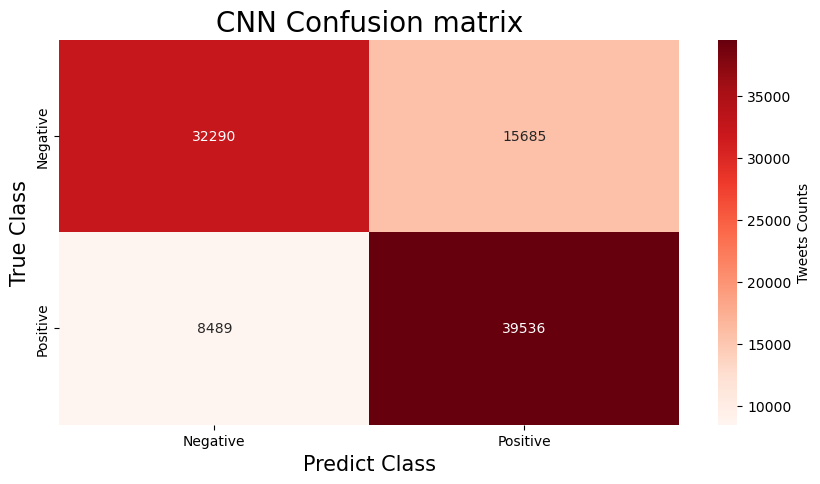

In [49]:
# CNN confusion matrix
CM_CNN = confusion_matrix(y_test, y_pred_cnn)

# plot CNN confusion matrix 
plt.figure(figsize=(10,5))
LS_labels = ['Negative', 'Positive']
sb.heatmap(CM_CNN, cmap = plt.cm.Reds, annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)
plt.xlabel('Predict Class', fontsize = 15)
plt.ylabel('True Class', fontsize = 15)
plt.title('CNN Confusion matrix', fontsize = 20)
plt.show()

## 4.3 Comparison and Conclusion

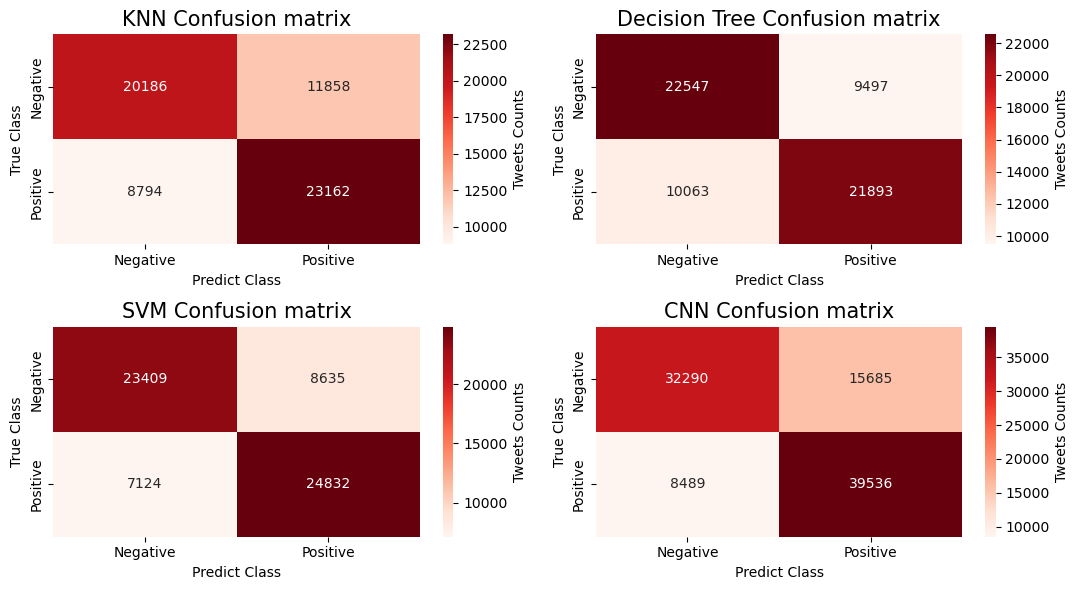

In [50]:
# Create a figure with 4 subplots
fig, ax = plt.subplots(2, 2, figsize=(11, 6))

LS_labels = ['Negative', 'Positive']

# Plot the KNN confusion matrix
sb.heatmap(CM_KNN, cmap = plt.cm.Reds, ax= ax[0][0], annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax[0][0].set_xlabel('Predict Class', fontsize = 10)
ax[0][0].set_ylabel('True Class', fontsize = 10)
ax[0][0].set_title('KNN Confusion matrix', fontsize = 15)

# Plot the Decision Tree confusion matrix
sb.heatmap(CM_DT, cmap = plt.cm.Reds, ax= ax[0][1], annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax[0][1].set_xlabel('Predict Class', fontsize = 10)
ax[0][1].set_ylabel('True Class', fontsize = 10)
ax[0][1].set_title('Decision Tree Confusion matrix', fontsize = 15)

# Plot the SVM confusion matrix
sb.heatmap(CM_SVM, cmap = plt.cm.Reds, ax= ax[1][0], annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax[1][0].set_xlabel('Predict Class', fontsize = 10)
ax[1][0].set_ylabel('True Class', fontsize = 10)
ax[1][0].set_title('SVM Confusion matrix', fontsize = 15)

# Plot the CNN confusion matrix
sb.heatmap(CM_CNN, cmap = plt.cm.Reds, ax= ax[1][1], annot = True, cbar_kws = {'label': 'Tweets Counts'}, fmt = 'd',  
            xticklabels = LS_labels,
            yticklabels = LS_labels)

ax[1][1].set_xlabel('Predict Class', fontsize = 10)
ax[1][1].set_ylabel('True Class', fontsize = 10)
ax[1][1].set_title('CNN Confusion matrix', fontsize = 15)

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [51]:
# Create a list of dictionaries with the results for each model
results = [
    {'Model': 'KNN', 'Accuracy': accuracy_knn},
    {'Model': 'Decision Tree', 'Accuracy': accuracy_dt},
    {'Model': 'SVM', 'Accuracy': accuracy_svm},
    {'Model': 'CNN', 'Accuracy': accuracy_cnn},
]

# Create the DataFrame
df_models = pd.DataFrame(results, columns=['Model', 'Accuracy'])

# Display the DataFrame
df_models

,Model,Accuracy
0,KNN,0.677312
1,Decision Tree,0.694375
2,SVM,0.753766
3,CNN,0.748188


- We applied a convolutional neural network (CNN) model based on the word2vec word embeddings- CNN model may be a strong contender for this particular task when using word2vec word embeddings. Results shows that CNN is close similar to SVM when it is coming for the accuracy. But still the SVM is getting the highest accuracy rate.